# Определение перспективного тарифа для телеком-компании

# Введение

**Заказчик:**  
Коммерческий департамент ООО "Мегалайн"

**Цель:**  
Понять, какой тариф приносит больше денег.

**Задача:**  
Проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**План исследования:**  
1. Первым шагом будет произведено первичное изучение и предобработка данных
2. На основании имеющихся данных рассчитаем необходимые показатели и подготовим данные к исследовательскому этапу.
3. Проведем исследовательский анализ данных и изучим поведение пользователей: количество и длительность звонков, количество сообщений и объем интернет траффика, который требуется пользователям оператора сотовой связи в среднем на ежемесячной основе.
4. Проанализируем среднюю ежемесячную выручку абонентов и, с приминением статистических методов, проверим:
- Есть ли различия между средней выручкой пользователей тарифов «Ультра» и «Смарт»;
- Есть ли различия между средней выручкой пользователей из Москвы и выручкой, полученной от пользователей из других регионов.  

**Описание данных:**  
Имееется выборка 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.  
Данные содержатся в следующих таблицах:  
1. Таблица `users` (информация о пользователях):
- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tarif` — название тарифного плана 

2. Таблица `calls` (информация о звонках):
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

3. Таблица  `messages` (информация о сообщениях):
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

4. Таблица `internet` (информация об интернет-сессиях):
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

5. Таблица `tariffs` (информация о тарифах):
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Подготовка окружения и импорт необходимых библиотек

Импортируем все необходимые библиотеки. Зададим необходимые настройки для библиотек.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

## Общее ознакомление с данными

Прочитаем данные из 5 файлов и сохраним их в соответсвующие переменные.

In [2]:
data_users = pd.read_csv('/datasets/users.csv')
data_calls = pd.read_csv('/datasets/calls.csv')
data_messages = pd.read_csv('/datasets/messages.csv')
data_internet = pd.read_csv('/datasets/internet.csv')
data_tariffs = pd.read_csv('/datasets/tariffs.csv')

Ознакомимся с каждым из датафреймов по порядку и изучим общую информацию. Выделим моменты, на которые стоит обратить внимание.

### `data_users` - информация о пользователях

In [3]:
data_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [4]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Проверим на наличие дубликатов, а также на наличие дуликатов отдельно в столбце `user_id`

In [5]:
print("Дубликатов в датафрейме: ", data_users.duplicated().sum())
print("Дубликатов в столбце user_id: ", data_users.duplicated(subset='user_id').sum())

Дубликатов в датафрейме:  0
Дубликатов в столбце user_id:  0


**На что стоит обратить внимание:**  
- В датафрейме содержится 38 клиентов, которые к моменту выгрузки данных перестали быть пользователями указанных тарифов.

### `data_calls` - информация о звонках

In [6]:
data_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [7]:
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [8]:
print("Дубликатов в датафрейме: ", data_calls.duplicated().sum())
print("Уникальных значений в столбце user_id (ожидаем 500): ", data_calls.user_id.nunique())

Дубликатов в датафрейме:  0
Уникальных значений в столбце user_id (ожидаем 500):  492


Посмотрим, какие абоненты отсутсвуют. Добавим их в список `data_calls_abscent_users`

In [9]:
data_calls_abscent_users = []

for i in range(1000, 1500):
    if i not in data_calls['user_id'].unique():
        print(f'Абонент {i} отсутствует')
        data_calls_abscent_users.append(i)
data_calls_abscent_users

Абонент 1091 отсутствует
Абонент 1106 отсутствует
Абонент 1128 отсутствует
Абонент 1231 отсутствует
Абонент 1328 отсутствует
Абонент 1371 отсутствует
Абонент 1473 отсутствует
Абонент 1489 отсутствует


[1091, 1106, 1128, 1231, 1328, 1371, 1473, 1489]

**На что стоит обратить внимание:**  
- Данные присутствуют только для 492 пользователей из 500
- Отсутствует информация для абонентов под номерами [1091, 1106, 1128, 1231, 1328, 1371, 1473, 1489]

### `data_messages` - информация о сообщениях

In [10]:
data_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [11]:
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [12]:
print("Дубликатов в датафрейме: ", data_messages.duplicated().sum())
print("Уникальных значений в столбце user_id (ожидаем 500): ", data_messages.user_id.nunique())

Дубликатов в датафрейме:  0
Уникальных значений в столбце user_id (ожидаем 500):  426


Посмотрим, какие абоненты отсутствуют. Добавим их в список `data_messages_abscent_users`

In [13]:
data_messages_abscent_users = []

for i in range(1000, 1500):
    if i not in data_messages['user_id'].unique():
        data_messages_abscent_users.append(i)

**На что стоит обратить внимание:**  
- Данные о собщениях представлены только для 426 пользователей из 500. Номера об отсутсвующих пользователях хранятся в списке `data_messages_abscent_users`

### `data_internet` - информация об интернет-сессиях

In [14]:
data_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [15]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [16]:
print("Дубликатов в датафрейме: ", data_internet.duplicated().sum())
print("Уникальных значений в столбце user_id (ожидаем 500): ", data_internet.user_id.nunique())

Дубликатов в датафрейме:  0
Уникальных значений в столбце user_id (ожидаем 500):  497


Посмотрим, какие абоненты отсутствуют. Добавим их в список `data_internet_abscent_users`

In [17]:
data_internet_abscent_users = []

for i in range(1000, 1500):
    if i not in data_internet['user_id'].unique():
        print(f'Абонент {i} отсутствует')
        data_internet_abscent_users.append(i)
data_internet_abscent_users

Абонент 1128 отсутствует
Абонент 1273 отсутствует
Абонент 1371 отсутствует


[1128, 1273, 1371]

**На что стоит обратить внимание:**  
- Столбец `Unnamed: 0` судя по всему дублирует индекс. Его можно удалить.  
- Данные присутствуют для 497 пользователей. Информация отсутсвует для пользователей: [1128, 1273, 1371]

### `data_tariffs` - информация о тарифах

In [18]:
data_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


С данной таблице все в порядке.

Посмотрим на пересечения списков `data_calls_abscent_users`, `data_messages_abscent_users`, `data_internet_abscent_users`. Есть ли пользователи, которые вовсе не пользовались услугами оператора за текущий период?

In [19]:
list_of_all_abscents = data_calls_abscent_users + data_messages_abscent_users + data_internet_abscent_users
totally_abscent = []

for user in list_of_all_abscents:
    count = list_of_all_abscents.count(user)
    if count == 3:
        totally_abscent.append(user)
totally_abscent = set(totally_abscent)

print(f'Для абонентов под номерами {totally_abscent} отсутсвует информация по использованным услугам.') 

Для абонентов под номерами {1128, 1371} отсутсвует информация по использованным услугам.


### Резюме

У нас есть 5 таблиц с данными. 3 из них содержат информацию о звонках, сообщениях и интернет-траффике, еще одна посвящена информации о пользователях, и одна описанию тарифов.  
В некоторых таблицах, есть моменты, на которые стоит обратить внимание.
1. `data_calls` - информация о звонках:  
- Данные присутствуют только для 492 пользователей из 500. Информация по абонентам под номерами [1091, 1106, 1128, 1231, 1328, 1371, 1473, 1489] отсутствует.

2. `data_messages` - информация о сообщениях:  
- Данные о собщениях представлены только для 426 пользователей из 500. Номера отсутсвующих пользователей хранятся в списке `data_messages_abscent_users`

3. `data_internet` - информация об интернет-сессиях:
- Столбец `Unnamed: 0` судя по всему дублирует индекс. Его можно удалить.  
- Данные присутствуют для 497 пользователей. Информация отсутсвует для пользователей: [1128, 1273, 1371]

4. `data_users` - информация о пользователях:
- В датафрейме содержится 38 клиентов, которые к моменту выгрузки данных перестали быть пользователями указанных тарифов.

Для абонентов под номерами {1128, 1371} полностью отсутсвует информация по использованным услугам.

Помимо этого, стоит отметить, что в таблицах `data_calls`, `data_messages` и `data_internet` не указаны тарифы пользователей. Возможно, будет удобным создать отдельный датафрейм с информацией "пользователь - тариф", чтобы присоеденить названия тарифов к каждой из вышеупомянутых таблиц.  
Явные пропуски и дубликаты в данных отсутсвуют.

## Предобработка данных

Изучим содержание каждого из датафреймов по порядку и подготовим их к анализу.  

В процессе предобработки:  
- Приведем данные к соответствующим типам
- Найдем и исправим ошибки в данных, если они есть.
- Добавим столбцы, которые нам будут полезны в дальнейших рассчетах.

### `data_users` - информация о пользователях

In [20]:
data_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [21]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


У нас имеется 2 столбца, которые хранят значения в формате `int64` и 6 столбцов с форматом хранения `object`. Рассмотрим эти группы по отдельности.

#### Формат `int`

In [22]:
data_users.select_dtypes('int').head()

,user_id,age
0,1000,52
1,1001,41
2,1002,59
3,1003,23
4,1004,68


Посмотрим на описание значения столбца `age`

In [23]:
data_users.age.describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

Создадим функцию, которая будет создавать 2 объекта *Axes* на одной *Figure*

In [24]:
def set_2ax_figure(title='', fontsize=15, figsize=(10, 4)):
    global ax1
    global ax2
    global fig
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, constrained_layout=True)
    fig.suptitle(title, fontsize=fontsize)
    return fig, ax1, ax2

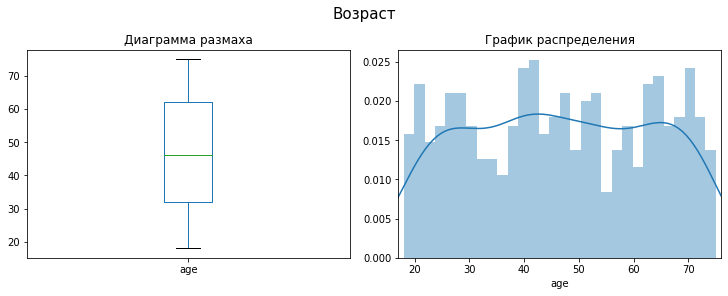

In [25]:
set_2ax_figure('Возраст')

data_users.age.plot(kind='box', ax=ax1);
ax1.set_title("Диаграмма размаха")

ax2 = sns.distplot(a=data_users.age, bins=30);
ax2.set_xlim(17, 76);
ax2.set_title('График распределения');

Можно заметить, что в данных присутсвуют пользователи от 18 до 75 лет.  
Средний возраст пользователя составляет 46 лет.  
Также можно заметить 4 основных пика: в районе 20 лет, 25 лет, в районе 40 лет и в районе 65 лет. Возможно, это связано с тем, что с точки зрения возраста клиентов, у оператора есть примерно 4 основных целевых аудитории. Судя по гистограмме, каждая из них представлена в достаточной степени.

В столбце `age` подозрительных значений не найдено.  
Со столбцом `user_id` также все в порядке. (Еще на этапе ознакомления с данными мы убедились в отсутствии в нем дубликатов)

#### Формат `object`

In [26]:
data_users.select_dtypes('O').head()

,churn_date,city,first_name,last_name,reg_date,tariff
0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


План действий:
- `churn_date` - приведем к формату *datetime*   
- `city` - проверим на наличие неявных дубликатов  
- `first_name` и `last_name` - эти столбцы не очень нас интересуют в контексте исследования.  
- `reg_date` - приведем к формату *datetime*  
- `tariff` - проверим на наличие неявных дубликатов, посмотрим распределение.  

1. Приведем столбец `churn_date` к формату *datetime*.

Изменим формат на *datetime* с параметром `errors='coerce'`, для того, чтобы конвертировать значения *NaN* в *NaT*

In [27]:
data_users.loc[:, 'churn_date'] = pd.to_datetime(data_users['churn_date'], errors='coerce')
print('Тип хранения данных в столбце churn_date:', data_users.churn_date.dtype)

Тип хранения данных в столбце churn_date: datetime64[ns]


Посмотрим на описание данных.

In [28]:
data_users['churn_date'].describe()

count                      38
unique                     33
top       2018-10-03 00:00:00
freq                        2
first     2018-08-17 00:00:00
last      2018-12-30 00:00:00
Name: churn_date, dtype: object

Посмотрим как распеделены месяца в которые клиенты отказывались от текущего тарифа.

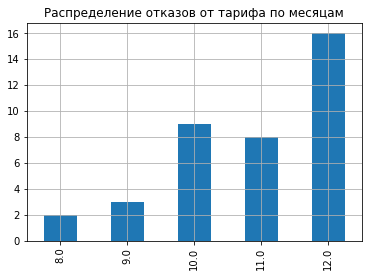

In [29]:
data_users.churn_date.dt.month.value_counts().sort_index().plot(kind='bar', grid=True);
plt.title('Распределение отказов от тарифа по месяцам');

Можно заметить, что начиная с августа клиенты начали прекращать пользоваться текущим тарифом. Пик отказов пришелся на декабрь.

Интересно, это поведение характерно для пользователей какого-то одного тарифа или одинаково для обоих.  
Возьмем срез данных с отказами и посмотрим, какими тарифами пользовались клиенты.

In [30]:
data_users[data_users.churn_date.notna()]['tariff'].value_counts()

smart    23
ultra    15
Name: tariff, dtype: int64

От тарифа smart отказались незначительно большее количество пользователей, однако c учетом того, что тарифом smart в целом пользуется большее количество абонентов, можно утверждать с определенной доле уверенности, что значения распределены равномерно.  Нет оснований полагать, что отток как-то связан с одним из тарифов. Возможно, это нормальный процент оттока для оператора в целом.

В целом, со значениями данного столбца все в порядке.

2. Проверим столбец `city` на наличие неявных дубликатов.

In [31]:
print('Уникальных значений в столбце city:', data_users.city.nunique())
data_users.city.unique()

Уникальных значений в столбце city: 76


array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

Все в порядке.

3. Изучим столбец `reg_time`. Приведем его к формату *datetime*

In [32]:
data_users.loc[:, 'reg_date'] = pd.to_datetime(data_users.loc[:, 'reg_date'])
data_users.loc[:, 'reg_date'].head()

0   2018-05-25
1   2018-11-01
2   2018-06-17
3   2018-08-17
4   2018-05-14
Name: reg_date, dtype: datetime64[ns]

Посмотрим на описание значений данного столбца.

In [33]:
data_users.reg_date.describe()

count                     500
unique                    270
top       2018-05-28 00:00:00
freq                        8
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: reg_date, dtype: object

Посмоторим на распределение данных.

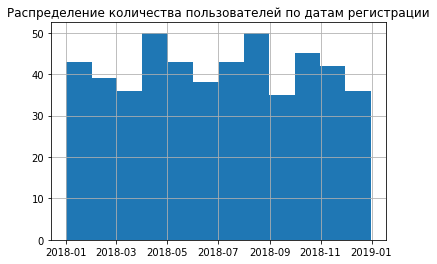

In [34]:
data_users.reg_date.hist(bins=12);
plt.title('Распределение количества пользователей по датам регистрации');

Похоже, что в январе, апреле, октябре (и возможно в августе) компания проводила промоакции. Об этом можно судить по пикам на гистограмме, и постепенным спадам после.  
В целом график близок по форме к равномерному распределение.

Аномалий не обнаружено.

4. Изучим столбец `tariff`. Приведем его к формату *category*

Посмотрим на уникальные значения.

In [35]:
data_users.tariff.unique()

array(['ultra', 'smart'], dtype=object)

Дубликатов нет. Можно преобразовать столбец к формату хранения данных *category*

In [36]:
data_users.loc[:, 'tariff'] = data_users.loc[:, 'tariff'].astype('category')
print('Тип хранения данных в столбце tariff:', data_users.tariff.dtype)

Тип хранения данных в столбце tariff: category


Посмотрим на распределение пользователей по тарифам.

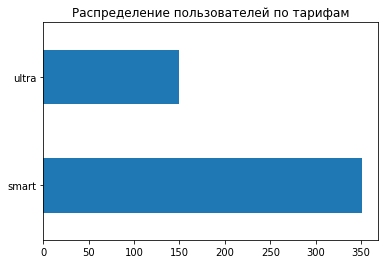

In [37]:
data_users['tariff'].value_counts().plot(kind='barh')
plt.title('Распределение пользователей по тарифам');

Можно заметить, что количество пользователей тарифа *Smart* превышает количество пользователей тарифа *Ultra* более в 2 раза. Это не удивительно, так как тариф *Ultra* дороже и включает в себя бОльшие пакеты услуг, которые могут не быть востребованы большинством абонентов.

**Датафрейм `data_users` готов к анализу**

Посмотрим первые 5 строк, а также информацию о датафрейме `data_users` после преобразования

In [38]:
data_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [39]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null category
dtypes: category(1), datetime64[ns](2), int64(2), object(3)
memory usage: 28.1+ KB


### `data_calls` - информация о звонках

Выведем на экран первые 5 строк датафрейма `data_calls`, а также информацию о нем.

In [40]:
data_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [41]:
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


План действий:  
- Преобразуем столбец `call_date` к формату *datetime*
- Добавим стобец `call_month`, в который сохраним месяц, в который был произведен звонок.
- Изучим столбец `duration`
- Добавим столбец `paid_duration`, в который сохраним длительность разговора в минутах, округленную в большую сторону (в соответсвиии с условиями тарифа)

1. Столбец `call_date`

Преобразуем столбец `call_date` к формату *datetime*

In [42]:
data_calls.loc[:, 'call_date'] = pd.to_datetime(data_calls['call_date'])
print('Тип хранения данных в столбце call_date:', data_calls.call_date.dtype)

Тип хранения данных в столбце call_date: datetime64[ns]


Посмотрим на описание и распределение данных в столбце `call_date`

In [43]:
data_calls['call_date'].describe()

count                  202607
unique                    365
top       2018-12-31 00:00:00
freq                     1435
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: call_date, dtype: object

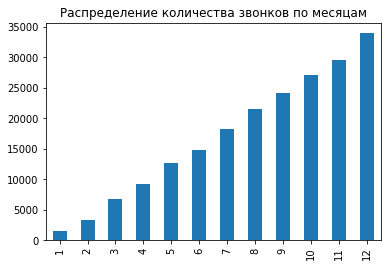

In [44]:
data_calls['call_date'].dt.month.value_counts().sort_index().plot(kind='bar');
plt.title('Распределение количества звонков по месяцам');

Данные представлены за период 2018-01-01 - 2018-12-31.  
Интересно, что с января по декабрь количество звонков равномерно росло. Пик звонков в декабре (который приходится на 31 декабря) может быть связан с тем, что пользователи звонят поздравить друг друга с Новогодними праздниками, однако почему в течение года происходил такой равомерный рост - пока что понятно плохо. 

2. Добавим стобец `call_month`, в который сохраним месяц, в который был произведен звонок.

In [45]:
data_calls['call_month'] = data_calls['call_date'].dt.month
data_calls[['call_date', 'call_month']].head()

,call_date,call_month
0,2018-07-25,7
1,2018-08-17,8
2,2018-06-11,6
3,2018-09-21,9
4,2018-12-15,12


Готово

2. Столбец `duration`

Посмотрим на описание и на распределение данных в столбце `duration`

In [46]:
data_calls.duration.describe()

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

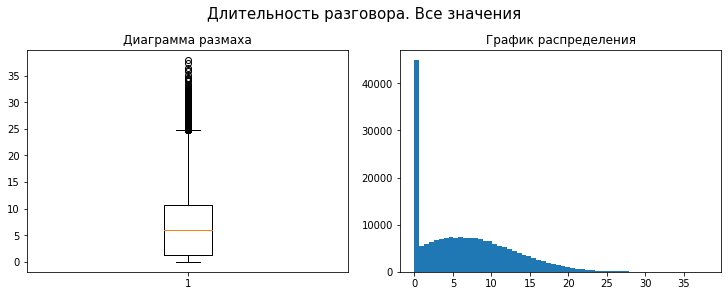

In [47]:
set_2ax_figure('Длительность разговора. Все значения')

ax1.boxplot(data_calls.duration);
ax1.set_title("Диаграмма размаха")

ax2.hist(data_calls.duration, bins=60);
ax2.set_title('График распределения');

Средняя длительность разговора составляет 6 минут, в то время как значения выше 25 мин - расцениваются как выбросы.

Можно заметить невероятно высокое количество звонков (более 40000) с нулевой длительностью разговора. Исходя из условий, мы знаем, что это непринятые звонки.  
Данные значения нам будет необходимо будет не учитывать при подсчете средней дительности разговора, так как неотвеченный звонок мы не можем считать за разговор.

Посмотрим как будет выглядеть описание данных, график распределения и диаграмма рассеяния для звонков с ненулевой длительностью звонка.

In [49]:
data_calls[data_calls.duration != 0]['duration'].describe()

count    162994.000000
mean          8.397794
std           5.353022
min           0.010000
25%           4.170000
50%           7.740000
75%          11.850000
max          38.000000
Name: duration, dtype: float64

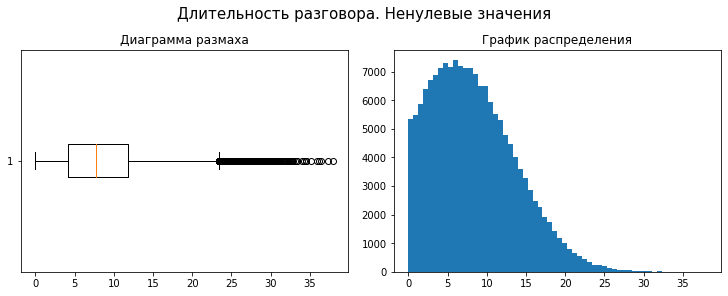

In [50]:
set_2ax_figure('Длительность разговора. Ненулевые значения')

ax1.boxplot(data_calls[data_calls.duration != 0]['duration'], vert=False);
ax1.set_title("Диаграмма размаха")

ax2.hist(data_calls[data_calls.duration != 0]['duration'], bins=60);
ax2.set_title('График распределения');

Теперь, средняя длительность звонка составляет уже около 8 минут (вместо изначальных 6-и), а граница, за которой лежат выбросы сместилась вниз и составляет около 23-24 минут.  
При этом минимальное значение все еще близко к нулю. Однако для нас лишь имеет значение, что оно больше нуля, так как такой звонок будет уже тарифицироваться как звонок длительностью в минуту.

3. Добавим столбец `paid_duration`

Добавим столбец `paid_duration`, в котором все звонки с нулевой длительностью для удобства подсчета средних величин сохраним как NaN, а оставшиеся значения округлим до ближайшего целого числа вверх методом `ceil` из библиотеки `math`

In [51]:
data_calls['paid_duration'] = data_calls['duration'].apply(ceil)
data_calls['paid_duration'].head()

0     0
1     0
2     3
3    14
4     6
Name: paid_duration, dtype: int64

Посмотрим на описание данных в столбце `paid_duration`, а также на диаграмму размаха и график распределения.

In [52]:
data_calls[data_calls['paid_duration'] > 0]['paid_duration'].describe()

count    162994.000000
mean          8.897880
std           5.353761
min           1.000000
25%           5.000000
50%           8.000000
75%          12.000000
max          38.000000
Name: paid_duration, dtype: float64

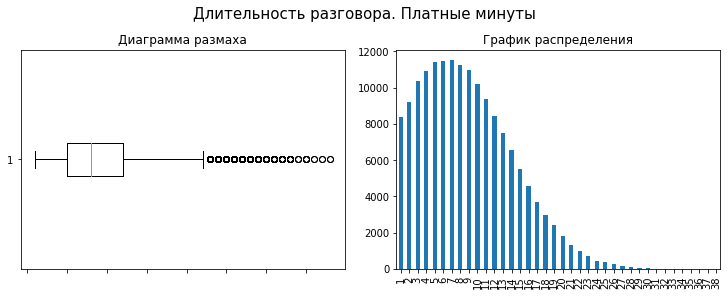

In [53]:
set_2ax_figure('Длительность разговора. Платные минуты')

ax1.boxplot(data_calls[data_calls['paid_duration'] > 0]['paid_duration'], vert=False);
ax1.set_title("Диаграмма размаха")
ax1.set_xticklabels('')

data_calls[data_calls['paid_duration'] > 0]['paid_duration'].value_counts().sort_index().plot(kind='bar', ax=ax2)
ax2.set_title('График распределения');

В целом средние значения остались те же. Изменилось лишь то, что теперь распределение времени разговора стало дискретным.

**Датафрейм `data_calls` готов к анализу**

Посмотрим информацию о датафрейме `data_calls` после преобразования.

In [54]:
data_calls.head()

,id,call_date,duration,user_id,call_month,paid_duration
0,1000_0,2018-07-25,0.00,1000,7,0
1,1000_1,2018-08-17,0.00,1000,8,0
2,1000_2,2018-06-11,2.85,1000,6,3
3,1000_3,2018-09-21,13.80,1000,9,14
4,1000_4,2018-12-15,5.18,1000,12,6


In [55]:
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 6 columns):
id               202607 non-null object
call_date        202607 non-null datetime64[ns]
duration         202607 non-null float64
user_id          202607 non-null int64
call_month       202607 non-null int64
paid_duration    202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 9.3+ MB


### `data_messages` - информация о сообщениях

Выведем на экран первые 5 строк датафрейма `data_messages`, а также информацию о нем.

In [56]:
data_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [57]:
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


План действий:  
- Столбец `message_date` - приведем к формату *datetime*, изучим его значения.
- Добавим столбец `message_month`, в который созраним месяц, когда было отправлено сообщение.

1. Столбец `message_date`

Приведем cтолбец `message_date к формату *datetime*

In [58]:
data_messages.loc[:, 'message_date'] = pd.to_datetime(data_messages['message_date'])
print('Тип хранения данных в столбце message_date:', data_messages.message_date.dtype)

Тип хранения данных в столбце message_date: datetime64[ns]


Посмотрим на описание данных столбца *message_date*

In [59]:
data_messages['message_date'].describe()

count                  123036
unique                    364
top       2018-12-31 00:00:00
freq                      859
first     2018-01-02 00:00:00
last      2018-12-31 00:00:00
Name: message_date, dtype: object

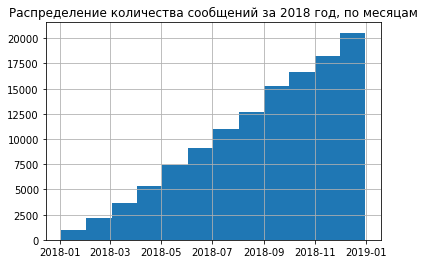

In [60]:
data_messages['message_date'].hist(bins=12);
plt.title('Распределение количества сообщений за 2018 год, по месяцам');

Данные представлены за период 2018-01-02 по 2018-12-31.  
График распределения количества сообщений по месяцам напоминает график распределения количества звонков по месяцам. Наибольшее значение наблюдается 31 декабря, что опять же может быть связано с новогодними поздравлениями. Причина же, по которой количество сообщений растет в таком порядке от месяца к месяцу пока что не ясна. Возможно, это связано с приростом количества абонентов в течение года.

С данными все в порядке.

2. Создадим столбец `message_month`

Добавим столбец `message_month`, в который созраним месяц, когда было отправлено сообщение.

In [61]:
data_messages['message_month'] = data_messages['message_date'].dt.month
data_messages[['message_date', 'message_month']].head()

,message_date,message_month
0,2018-06-27,6
1,2018-10-08,10
2,2018-08-04,8
3,2018-06-16,6
4,2018-12-05,12


**Датафрейм `data_messages` готов к анализу**

Выведем первые 5 строк обновленного датафрейма `data_messages` и информацию о нем.

In [62]:
data_messages.head()

,id,message_date,user_id,message_month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [63]:
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
id               123036 non-null object
message_date     123036 non-null datetime64[ns]
user_id          123036 non-null int64
message_month    123036 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.8+ MB


### `data_internet` - информация об интернет-сессиях

Выведем на экран первые 5 строк датафрейма `data_internet`, а также информацию о нем.

In [64]:
data_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [65]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


План действий:  
- Удалим столбец `Unnamed: 0`, который судя по всему дублирует индекс таблицы.  
- Изучим значения столбца `mb_used`. (На данном этапе нам не нужно будет его приводить к гигабайтам, так как отдельные сессии не округляются. Округляться в большую сторону будет сумма израсходованных мегабайт за месяц)
- Изучим столбец `session_date`. Для этого преобразуем его в формат *datetime*  
- Добавим столбец `session_month`, в который сохраним месяц интернет-сессии

1. Столбец `Unnamed: 0`

Удалим столбец `Unnamed: 0`

In [66]:
data_internet = data_internet.drop('Unnamed: 0', axis=1)
data_internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Готово.

2. Столбeц `mb_used`

Изучим значения столбца `mb_used`.   

In [67]:
data_internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

Среднее количество мегабайт, которое использовали абоненты за одну сессию составляет 348 мб (по медиане). Среднее арифметическое чуть выше и составляет 370 мб на одну сессию. 
Присутсвуют сессии с 0 затратами гигибайт.

Посмотрим на диаграмму разброса и график распределения.

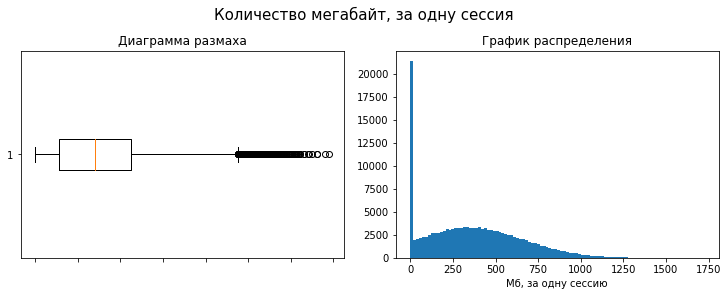

In [68]:
set_2ax_figure(title='Количество мегабайт, за одну сессия')

ax1.boxplot(data_internet['mb_used'], vert=False);
ax1.set_title('Диаграмма размаха')
ax1.set_xticklabels('')

ax2.hist(data_internet['mb_used'], bins=100);
ax2.set_title('График распределения');
ax2.set_xlabel('Мб, за одну сессию');

Длинный хвост на гистограмме, уходящий вправо можно объяснить тем, что в данных, которые мы сейчас рассматриваем объеденены пользователи из двух тарифов, и пользователи, которые обладают большими лимитами могут позволить себе тратить большее количество мегабайт за сессию. Это с одной стороны, с другой же стороны каждому из нас в какой-то момент может понадобиться скачать тяжелый файл, и такие значения могут встречаться не только у абонентов более дорогого тарифа. Более подробно средняя длительность сессии для абонентов каждого из тарифов будет рассмотрена на этапе исследовательского анализа.

Нулевые же значения вероятнее всего возникли из-за того, что пользователь попытался войти в интернет, но в результате отсутствия связи, ему это не удалось. Следовательно, имеет смысл посмотреть описание данных для сессии, использование мегабайт в которых больше 0, так как такое большое количество нулевых значений может сильно искажать показатели среднего.

In [69]:
data_internet[data_internet['mb_used'] > 0]['mb_used'].describe()

count    129798.000000
mean        426.087210
std         255.596447
min           0.030000
25%         227.460000
50%         400.540000
75%         592.947500
max        1724.830000
Name: mb_used, dtype: float64

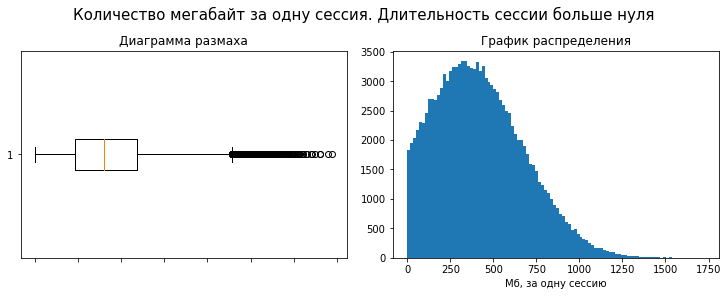

In [70]:
set_2ax_figure(title='Количество мегабайт за одну сессия. Длительность сессии больше нуля')

ax1.boxplot(data_internet[data_internet['mb_used'] > 0]['mb_used'], vert=False);
ax1.set_title('Диаграмма размаха')
ax1.set_xticklabels('')

ax2.hist(data_internet[data_internet['mb_used'] > 0]['mb_used'], bins=100);
ax2.set_title('График распределения');
ax2.set_xlabel('Мб, за одну сессию');

Среднее количество использованных мегабайт за одну сессию выросло с 348 до 400.5 мб (по медиане), и с 370 до 426 мб по среднему арифметическому.  
При этом, лишь 25% пользователей из полученной выборки используют более 592.9 мб за одну сессию.

Помимо большого количества нулевых интернет-сессий, в столбце `mb_used` аномалий не найдено.

3. Столбец `session_date`.

Преобразуем формат хранения данных в столбце `session_date` в формат *datetime*

In [71]:
data_internet.loc[:, 'session_date'] = pd.to_datetime(data_internet['session_date'])
print('Тип хранения данных в столбце session_date:', data_internet.session_date.dtype)
data_internet.loc[:, 'session_date'].head()

Тип хранения данных в столбце session_date: datetime64[ns]


0   2018-11-25
1   2018-09-07
2   2018-06-25
3   2018-08-22
4   2018-09-24
Name: session_date, dtype: datetime64[ns]

Посмотрим на описание данных.

In [72]:
data_internet.loc[:, 'session_date'].describe()

count                  149396
unique                    365
top       2018-12-31 00:00:00
freq                     1057
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: session_date, dtype: object

Данные об интернет сессиях представлены с 2018-01-01 по 2018-12-31.

Посмотрим на распределение количества интернет-сессий по датам.

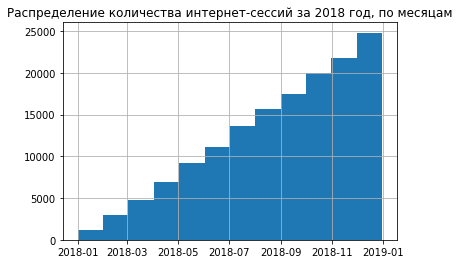

In [73]:
data_internet['session_date'].hist(bins=12);
plt.title('Распределение количества интернет-сессий за 2018 год, по месяцам');

Количество интернет сессий (также как и количество звонков и сообщений) возрастает от месяца к месяцу в течение года.  
Пик вновь приходится на 31 декабря.

С данными все в порядке. Можно идти дальше.

4. Добавим столбец `session_month`.

Добавим столбец `session_month`, в который сохраним месяц интернет-сессии

In [74]:
data_internet['session_month'] = data_internet['session_date'].dt.month
data_internet[['session_date', 'session_month']].head()

,session_date,session_month
0,2018-11-25,11
1,2018-09-07,9
2,2018-06-25,6
3,2018-08-22,8
4,2018-09-24,9


Готово.

**Датафрейм `data_internet` готов к анализу**

Выведем первые 5 строк обновленного датафрейма `data_internet` и информацию о нем.

In [75]:
data_internet.head()

,id,mb_used,session_date,user_id,session_month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


In [76]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
id               149396 non-null object
mb_used          149396 non-null float64
session_date     149396 non-null datetime64[ns]
user_id          149396 non-null int64
session_month    149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


### `data_tariffs` - информация о тарифах

Выведем на экран первые 5 строк датафрейма `data_internet`, а также информацию о нем.

In [77]:
data_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [78]:
data_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


В целом с таблице все в порядке.

Для удобства обращения к данным в таблице можно переименовать индекс в навание тарифа 

In [79]:
data_tariffs.index = data_tariffs['tariff_name'].to_list()

In [80]:
data_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
smart,50,15360,500,550,200,3,3,smart
ultra,1000,30720,3000,1950,150,1,1,ultra


Готово.

### Резюме

На данном этапе мы изучили по порядку каждую из таблиц.
В каждой таблице мы:
- Изучили данные, которые она в себе содержит
- Привели данные к соответсвующим типам.
- Проверели данные на предмет аномальных значений и ошибок, а также обработали их необходимым образом.
- Добавили новые столбцы, которые могут пригодиться нам в дальнейшем анализе там, где это было необходимо.

## Подготовка данных к анализу. Рассчет необходимых метрик

На данном этапе, посчитаем для каждого пользователя:
- Количество сделанных звонков и израсходованных минут разговора по месяцам;
- Количество отправленных сообщений по месяцам;
- Объем израсходованного интернет-трафика по месяцам;
- Помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

### Количество и длительность звонков

Создадим словарь, в котором сохраним значения "id пользователя - тарифный план", чтобы мы могли присоединять его к нужным таблицам. В качестве индекса, используем столбец `user_id`

In [81]:
users_dict = pd.DataFrame(data_users['user_id']).join(data_users['tariff']).set_index('user_id')
users_dict.head()

,tariff
user_id,
1000,ultra
1001,smart
1002,smart
1003,ultra
1004,ultra


Создадим таблицу, в которой сохраним количество израсходованных минут каждого пользователя по месяцам.  
Присоеденим к созданной таблице тарифы для каждого пользователя.

In [82]:
#выведем на экран первые 5 строк таблицы data_calls
data_calls.head() 

,id,call_date,duration,user_id,call_month,paid_duration
0,1000_0,2018-07-25,0.00,1000,7,0
1,1000_1,2018-08-17,0.00,1000,8,0
2,1000_2,2018-06-11,2.85,1000,6,3
3,1000_3,2018-09-21,13.80,1000,9,14
4,1000_4,2018-12-15,5.18,1000,12,6


In [83]:
#Создадим сводную таблицу

calls_duration_monthly_pivot = data_calls.pivot_table(index='user_id', columns='call_month', 
                                                      values='paid_duration', aggfunc='sum')

calls_duration_monthly_pivot = calls_duration_monthly_pivot.join(users_dict)

calls_duration_monthly_pivot.head()

,1,2,3,4,5,6,7,8,9,10,11,12,tariff
user_id,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0,ultra
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0,smart
1002,NaN,NaN,NaN,NaN,NaN,117.0,214.0,289.0,206.0,212.0,243.0,236.0,smart
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,961.0,855.0,824.0,802.0,ultra
1004,NaN,NaN,NaN,NaN,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0,ultra


Создадим таблицу, в которой сохраним количество ненулевых звонков каждого пользователя за месяц. (В данном случае, нас не интересуют звонки с нулевой длительностью, так как данный тип звонка является непринятым, и следовательно, в рамках исследования не имеет смысла считать его за совершенный звонок)  

Присоеденим к созданной таблице тарифы для каждого пользователя.

In [84]:
calls_number_monthly_pivot = data_calls[data_calls['paid_duration'] > 0].pivot_table(index='user_id', columns='call_month', 
                                                    values='paid_duration', aggfunc='count')

calls_number_monthly_pivot = calls_number_monthly_pivot.join(users_dict)

calls_number_monthly_pivot.head()

,1,2,3,4,5,6,7,8,9,10,11,12,tariff
user_id,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,17.0,28.0,41.0,42.0,46.0,44.0,37.0,38.0,ultra
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,47.0,smart
1002,NaN,NaN,NaN,NaN,NaN,14.0,21.0,37.0,25.0,24.0,25.0,27.0,smart
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,105.0,97.0,95.0,88.0,ultra
1004,NaN,NaN,NaN,NaN,7.0,25.0,20.0,18.0,18.0,21.0,15.0,15.0,ultra


### Количество сообщений

Создадим таблицу, в которой сохраним количество сообщений, отправленных каждым пользователем по месяцам.  
Присоеденим к созданной таблице тарифы для каждого пользователя.

In [85]:
messages_number_monthly_pivot = data_messages.pivot_table(index='user_id', columns='message_month', 
                                                          values='id', aggfunc='count')

messages_number_monthly_pivot = messages_number_monthly_pivot.join(users_dict)

messages_number_monthly_pivot.head()

,1,2,3,4,5,6,7,8,9,10,11,12,tariff
user_id,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0,ultra
1002,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0,smart
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0,ultra
1004,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0,ultra
1005,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0,smart


### Объем интернет-траффика

Рассчитаем объем интернет-траффика, который пользователи тратили по месяцам. Присоеденим к созданной таблице тарифы для каждого пользователя.

In [86]:
internet_monthly_pivot = data_internet.pivot_table(index='user_id', columns='session_month', 
                                                   values='mb_used', aggfunc='sum')

internet_monthly_pivot = internet_monthly_pivot.join(users_dict)

internet_monthly_pivot.head()

,1,2,3,4,5,6,7,8,9,10,11,12,tariff
user_id,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,2253.49,23233.77,14003.64,14055.93,14568.91,14702.49,14756.47,9817.61,ultra
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18429.34,14036.66,smart
1002,NaN,NaN,NaN,NaN,NaN,10856.82,17580.10,20319.26,16691.08,13888.25,18587.28,18113.73,smart
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8565.21,12468.87,14768.14,11356.89,10121.53,ultra
1004,NaN,NaN,NaN,NaN,13403.98,17600.02,22229.58,28584.37,15109.03,18475.44,15616.02,18021.04,ultra


### Помесячная выручка с каждого пользователя

Вначале, мы рассчитаем выручку по отдельности за звонки, сообщения и мобильный траффик. Затем сложим получившиеся значения.

#### Звонки

Выведем на экран таблицы `calls_duration_monthly_pivot` и `data_tariffs`

In [87]:
calls_duration_monthly_pivot.head()

,1,2,3,4,5,6,7,8,9,10,11,12,tariff
user_id,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0,ultra
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0,smart
1002,NaN,NaN,NaN,NaN,NaN,117.0,214.0,289.0,206.0,212.0,243.0,236.0,smart
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,961.0,855.0,824.0,802.0,ultra
1004,NaN,NaN,NaN,NaN,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0,ultra


In [88]:
data_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
smart,50,15360,500,550,200,3,3,smart
ultra,1000,30720,3000,1950,150,1,1,ultra


Создадим функцию, которая будет возвращать 0, если значение, переданное в нее меньше или равно нулю

In [89]:
def return_0_for_non_overlimit(value):
    if value <= 0:
        return 0
    else:
        return value

Создадим пустой датафрей `data_calls_revenue`, в который в дальнейшем сохраним значение выручки по каждому клиенту.

In [90]:
data_calls_revenue = pd.DataFrame()

Создадим цикл, в котором рассчитаем выручку по каждому пользователю за переплаченные минуты и заполним датафрейм `data_calls_revenue` соответствующими значениями.

In [91]:
for tariff, grouped_data in calls_duration_monthly_pivot.groupby('tariff'):
    for month in grouped_data.columns[:12]:
        for user_id in grouped_data.index:
            #Н аходим: израсходованные минуты - лимит минут = минуты сверх тарифа
            overmin = (grouped_data.loc[user_id, month] - data_tariffs.loc[tariff, 'minutes_included']) 
            # Если остаток меньше или равен 0 -> возвращаем 0
            overpay_min = return_0_for_non_overlimit(overmin) #кол-во минут сверх лимита.
            # Находим сумму к оплате за количество минут сверх лимита
            overpay_total = overpay_min*data_tariffs.loc[tariff, 'rub_per_minute']
            data_calls_revenue.loc[user_id, month] = overpay_total        

Выведем получившийся датафрейм на экран.

In [92]:
data_calls_revenue.head()

,1,2,3,4,5,6,7,8,9,10,11,12
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1002,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005,0.0,0.0,318.0,636.0,285.0,336.0,207.0,357.0,0.0,669.0,141.0,276.0
1006,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1007,NaN,NaN,NaN,0.0,0.0,135.0,231.0,0.0,465.0,0.0,240.0,0.0


Отсортируем столбцы и индексы датафрейма, а также присоеденим наименование тарифов для каждого пользователя

In [93]:
data_calls_revenue = data_calls_revenue.sort_index(axis=1).sort_index()
data_calls_revenue.head()

,1,2,3,4,5,6,7,8,9,10,11,12
1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1002,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Сообщения

Выведем на экран таблицы `messages_number_monthly_pivot` и `data_tariffs`

In [94]:
messages_number_monthly_pivot.head()

,1,2,3,4,5,6,7,8,9,10,11,12,tariff
user_id,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0,ultra
1002,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0,smart
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0,ultra
1004,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0,ultra
1005,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0,smart


In [95]:
data_tariffs[['messages_included', 'rub_per_message']]

,messages_included,rub_per_message
smart,50,3
ultra,1000,1


Создадим пустой датафрейм `data_messages_revenue`. Созраним в него сумму, которые абоненты заплатили за отправленные сверх лимита сообщения.  
Заполним его в цикле

In [96]:
data_messages_revenue = pd.DataFrame()

In [97]:
for tariff, grouped_data in messages_number_monthly_pivot.groupby('tariff'):
    for month in grouped_data.columns[:12]:
        for user_id in grouped_data.index:
            # Находим: израсходованные сообщения - лимит сообщений = сообщения сверх тарифа
            overmes = (grouped_data.loc[user_id, month] - data_tariffs.loc[tariff, 'messages_included']) 
            # Если остаток меньше или равен 0 -> возвращаем 0
            overpay_mes = return_0_for_non_overlimit(overmes) #кол-во сообщений сверх лимита.
            # Находим сумму к оплате за количество сообщений сверх лимита
            overpay_total = overpay_mes*data_tariffs.loc[tariff, 'rub_per_message']
            data_messages_revenue.loc[user_id, month] = overpay_total  

Отсортируем индексы. Добавим столбец с тарифами. Выведем таблицу `data_messages_revenue` на экран

In [98]:
data_messages_revenue = data_messages_revenue.sort_index()
data_messages_revenue.head()

,1,2,3,4,5,6,7,8,9,10,11,12
1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005,0.0,0.0,18.0,0.0,0.0,0.0,18.0,42.0,6.0,0.0,3.0,12.0


#### Интернет-траффик

Выведем на экран таблицы `internet_monthly_pivot` и `data_tariffs`

In [99]:
internet_monthly_pivot.head()

,1,2,3,4,5,6,7,8,9,10,11,12,tariff
user_id,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,2253.49,23233.77,14003.64,14055.93,14568.91,14702.49,14756.47,9817.61,ultra
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18429.34,14036.66,smart
1002,NaN,NaN,NaN,NaN,NaN,10856.82,17580.10,20319.26,16691.08,13888.25,18587.28,18113.73,smart
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8565.21,12468.87,14768.14,11356.89,10121.53,ultra
1004,NaN,NaN,NaN,NaN,13403.98,17600.02,22229.58,28584.37,15109.03,18475.44,15616.02,18021.04,ultra


In [100]:
data_tariffs[['mb_per_month_included', 'rub_per_gb']]

,mb_per_month_included,rub_per_gb
smart,15360,200
ultra,30720,150


Создадим пустой датафрейм `data_internet_revenue`. Сохраним в него сумму, которые абоненты заплатили за использованный сверх лимита интернет-траффик.  
Заполним его в цикле

In [101]:
data_internet_revenue = pd.DataFrame()

In [102]:
for tariff, grouped_data in internet_monthly_pivot.groupby('tariff'):
    for month in grouped_data.columns[:12]:
        for user_id in grouped_data.index:
            # Находим: израсходованные мегабайты - лимит мегабайт = мегабайт сверх тарифа
            overmb = (grouped_data.loc[user_id, month] - data_tariffs.loc[tariff, 'mb_per_month_included'])
            # Конвертируем мегабайты в гигабайты с округлением вверх. При этом, обработка Nan-значений выдает ошибку.
            # Чтобы обработать ошибку используем конструкцию "try-except"
            try:
                overgb = ceil(overmb / 1024)
            except:
                overgb = overmb
            # Если остаток меньше или равен 0 -> возвращаем 0
            overpay_gb = return_0_for_non_overlimit(overgb) #кол-во гигиабайт сверх лимита.
            # Находим сумму к оплате за количество гигиабайт сверх лимита
            overpay_total = overpay_gb*data_tariffs.loc[tariff, 'rub_per_gb']
            data_internet_revenue.loc[user_id, month] = overpay_total 

Отсортируем индексы. Добавим столбец с тарифами. Выведем таблицу `data_internet_revenue` на экран

In [103]:
data_internet_revenue = data_internet_revenue.sort_index()
data_internet_revenue.head()

,1,2,3,4,5,6,7,8,9,10,11,12
1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600.0,0.0
1002,NaN,NaN,NaN,NaN,NaN,0.0,600.0,1000.0,400.0,0.0,800.0,600.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Суммарная выручка по каждому абоненту

Итак, у нас есть 3 таблицы. Выведем их на экран

In [104]:
# Плата за минуты сверх лимита
data_calls_revenue.head()

,1,2,3,4,5,6,7,8,9,10,11,12
1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1002,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
# Плата за сообщения сверх лимита
data_messages_revenue.head()

,1,2,3,4,5,6,7,8,9,10,11,12
1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005,0.0,0.0,18.0,0.0,0.0,0.0,18.0,42.0,6.0,0.0,3.0,12.0


In [106]:
# Плата за траффик сверх лимита
data_internet_revenue.head()

,1,2,3,4,5,6,7,8,9,10,11,12
1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600.0,0.0
1002,NaN,NaN,NaN,NaN,NaN,0.0,600.0,1000.0,400.0,0.0,800.0,600.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Найдем сумму выручки, которую оператор получил за абонентскую активность сверх тарифного пакета.  
Сохраним значения в таблицу `overlimit_revenue`

Просуммируем значения всех трех таблиц. Используем параметр `fill_value=0`, для того, чтобы, если попадется пропущенное значение в одной таблице, а в другой таблице для нее будет присутствовать значение, результатом суммы получилось число, а не `NaN`. Если в ячейке мы видим число - для нас это знак, что данный пользователь в данный месяц пользовался тарифом. Если параметр не использовать, то некоторые числа могут превратиться в `NaN` (к примеру, если пользователь не отправил ни одного сообщения в текущем месяце, но совершал звонки)

In [107]:
overlimit_revenue = (
    data_calls_revenue
    .add(data_messages_revenue, fill_value=0)
    .add(data_internet_revenue, fill_value=0)
)

print(overlimit_revenue.shape)
overlimit_revenue.head()

(498, 12)


,1,2,3,4,5,6,7,8,9,10,11,12
1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600.0,0.0
1002,NaN,NaN,NaN,NaN,NaN,0.0,600.0,1000.0,400.0,0.0,800.0,600.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Небольшое отступление**

Всего у нас представлена информация по 498 абонентам. Не хватает 2х. Проверим, те же ли самые это 2 абонента, для которых у нас отсуствует информация по использованным услугам. Их номера хранятся в списке (точнее, в множестве) `totally_abscent`

Выведем на экран номер отсутствующих абонентов

In [108]:
list_1 = []
for i in range(1000, 1500):
    if i not in overlimit_revenue.index:
        print(f'Абонент {i} отсутсвует')

Абонент 1128 отсутсвует
Абонент 1371 отсутсвует


Посмотрим на список `totally_abscent`

In [109]:
totally_abscent

{1128, 1371}

Все верно. Значит, все остальные абоненты попали в таблицу `total_revenue`

Посмотрим, что это за пользователи такие.

In [110]:
data_users[(data_users['user_id'] == 1371) | (data_users['user_id'] == 1128)]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


Это пользователи, которые подключились в конце года, и спустя 5-8 дней отключились от тарифа.  
Посмотрим, много ли у нас таких пользователей, которые отключились ранее чем через 14 дней.  
Создадим таблицу `days_between_reg_churn`, в которой сохраним разницу между датой подключения тарифа и датой отказа от него.

In [111]:
days_between_reg_churn = data_users['churn_date'] - data_users['reg_date']

days_between_reg_churn.head()

0   NaT
1   NaT
2   NaT
3   NaT
4   NaT
dtype: timedelta64[ns]

Посмотрим, сколько абонентов пользовались услугами менее 14 дней.

In [112]:
days_between_reg_churn[days_between_reg_churn.dt.days < 14]

128   8 days
371   5 days
dtype: timedelta64[ns]

Те же самые 2 пользователя.  
Если бы таких пользователей было бы много, следовало бы проанализировать в чем может быть причина. В данном же случае, мы не будем заострять на них внимание.

**Вернемся к рассчету выручки**

Теперь нам необходимо для пользователей каждого тарифа прибавить стоимость ежемесячного обслуживания. Для этого, в первую очередь, присоеденим столбец с тарифами к таблице `overlimit_revenue`

In [113]:
overlimit_revenue = overlimit_revenue.join(users_dict)

overlimit_revenue.head()

,1,2,3,4,5,6,7,8,9,10,11,12,tariff
1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600.0,0.0,smart
1002,NaN,NaN,NaN,NaN,NaN,0.0,600.0,1000.0,400.0,0.0,800.0,600.0,smart
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,ultra
1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra


Выведем стоимость ежемесчного обслуживания тарифов на экран.

In [114]:
data_tariffs['rub_monthly_fee']

smart     550
ultra    1950
Name: rub_monthly_fee, dtype: int64

Создадим 2 пустых датафрейма:`total_revenue_smart` - здесь сохраним выручку от абонентов на тарифе "Смарт", и `total_revenue_ultra` - с выручкой, полученной от абонентов на тарифе "Ультра"

In [115]:
total_revenue_smart = pd.DataFrame()
total_revenue_ultra = pd.DataFrame()

Заполним эти 2 датафрейма в цикле.

In [116]:
for tariff, grouped_data in overlimit_revenue.groupby('tariff'):
    for month in grouped_data.columns[:12]:
        month_series = grouped_data[month] + data_tariffs.loc[tariff, 'rub_monthly_fee']
        if tariff == 'smart':
            total_revenue_smart = total_revenue_smart.join(month_series, how='outer')
        else:
            total_revenue_ultra = total_revenue_ultra.join(month_series, how='outer')

Посмотрим на получившиеся датафреймы.

In [117]:
total_revenue_smart.head()

,1,2,3,4,5,6,7,8,9,10,11,12
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1150.0,550.0
1002,NaN,NaN,NaN,NaN,NaN,550.0,1150.0,1550.0,950.0,550.0,1350.0,1150.0
1005,550.0,550.0,886.0,1186.0,835.0,886.0,775.0,949.0,556.0,1219.0,694.0,838.0
1006,NaN,550.0,950.0,550.0,550.0,550.0,1550.0,1350.0,750.0,1550.0,550.0,1350.0
1007,NaN,NaN,NaN,550.0,1150.0,685.0,981.0,1750.0,1015.0,550.0,990.0,550.0


In [118]:
total_revenue_ultra.head()

,1,2,3,4,5,6,7,8,9,10,11,12
1000,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0
1004,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
1013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,1950.0
1016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,1950.0


Проверим, что в каждом датафрейме у нас действительно сохранились значения того тарифа, который должен в нем быть. Для этого присоеденим столбец с тарифа методом `join` к каждому из датафреймов и выведем уникальные значения столбца `tariff`

In [119]:
print(f'В таблице total_revenue_smart содержатся пользователи тарифа {total_revenue_smart.join(users_dict).tariff.unique()[0]}')

В таблице total_revenue_smart содержатся пользователи тарифа smart


In [120]:
print(f'В таблице total_revenue_ultra содержатся пользователи тарифа {total_revenue_ultra.join(users_dict).tariff.unique()[0]}')

В таблице total_revenue_ultra содержатся пользователи тарифа ultra


In [121]:
print(f'В сумме в двух таблицах содержится {total_revenue_smart.shape[0] + total_revenue_ultra.shape[0]} строк')

В сумме в двух таблицах содержится 498 строк


Все сходится

### Резюме

На данном этапе мы создали несколько таблиц, на основе которых будем проводить дальнейшее исследования:  
- `calls_number_monthly_pivot` - количество звонков по каждому пользователю в месяц (длительностью свыше нуля)
- `calls_duration_monthly_pivot` - суммарная продолжительность звонков по каждому пользователю за месяц (каждый звонок перед подсчетом суммы был округлен в большую сторону, в соответствии с условиями оператора)
- `messages_number_monthly_pivot` - количество сообщений, отправленных каждым пользователем за месяц
- `internet_monthly_pivot` - количество трафика, которые абоненты использовали за месяц  
   
   
- `total_revenue_smart` - выручка, полученная от абонентов на тарифе *smart* (включая ежемесячный платеж и переплаты)
- `total_revenue_ultra` - выручка, полученная от абонентов на тарифе *ultra* (включая ежемесячный платеж и переплаты)

## Исследовательский анализ данных

На данном этапе мы опишем поведение клиентов оператора, исходя из выборки. Изучим:
- Сколько минут разговора требуется пользователям каждого тарифа в месяц;
- Сколько сообщений требуется пользователям каждого тарифа в месяц;
- Какой объём интернет-трафика требуется пользователям каждого тарифа в месяц;

### Длительность звонков.

Проанализируем, какое в среднем количество минут разговоров требуется пользователям каждого тарифа в месяц.

In [122]:
calls_duration_monthly_pivot.head()

,1,2,3,4,5,6,7,8,9,10,11,12,tariff
user_id,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0,ultra
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0,smart
1002,NaN,NaN,NaN,NaN,NaN,117.0,214.0,289.0,206.0,212.0,243.0,236.0,smart
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,961.0,855.0,824.0,802.0,ultra
1004,NaN,NaN,NaN,NaN,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0,ultra


Создадим таблицу `calls_duration_monthly_pivot_notnull` в которой сохраним только данные о длительности звонков свыше 0. Сделаем это путем заполнение нулей значениями `nan`

In [123]:
calls_duration_monthly_pivot_notnull = calls_duration_monthly_pivot.where(calls_duration_monthly_pivot != 0, np.nan)

Создадим 2 фильтра: для тарифа смарт и для тарифа ультра

In [124]:
smart_mask_calls = calls_duration_monthly_pivot_notnull['tariff'] == 'smart'
ultra_mask_calls = calls_duration_monthly_pivot_notnull['tariff'] == 'ultra'

Посмотрим, как распределена продолжительность разговоров для двух выборок по месяцам.

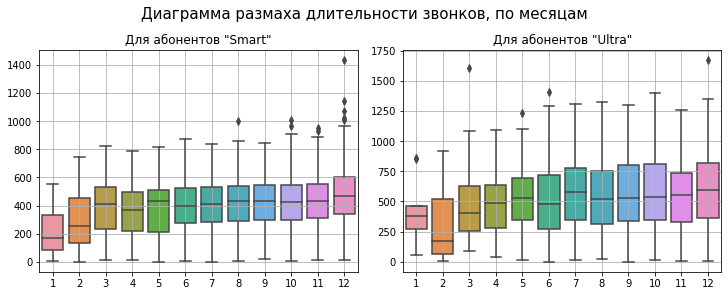

In [125]:
set_2ax_figure('Диаграмма размаха длительности звонков, по месяцам')

sns.boxplot(data=calls_duration_monthly_pivot_notnull[smart_mask_calls], 
            orient='v', ax=ax1);
ax1.set_title('Для абонентов "Smart"')

sns.boxplot(data=calls_duration_monthly_pivot_notnull[ultra_mask_calls], 
            orient='v', ax=ax2);
ax2.set_title('Для абонентов "Ultra"')
              
              
for ax in [ax1, ax2]:
    ax.grid()

Если сравнивать общую длительность звонков пользователей по каждому из месяцев, то можно увидеть, что суммарно пользователи внутри каждого из тарифов от месяца к месяцу тратят в среднем примерно одинаковое количество минут. При этом у пользователей тарифа Ультра это время в среднем выше и находится примерно на уровне 500 минут в месяц, в то время, как у абонентов тарифа Смарт среднее время потраченных в месяц минут располагается в районе 400.  
Интересно, что в феврале у пользователей обоих тарифов наблюдается более низкая продолжительность медианная продолжительность разговоров.  
Также, можно заметить, что у пользователей тарифа Ультра раброс потраченных минут в течение месяца выше, нежели у абонентов тарифа Смарт.  
В целом, можно утверждать, что длительность разговоров внутри каждой из выборок распределена равномерно по месяцам. 

Создадим столбцы с данными `calls_duration_smart_all` и `calls_duration_ultra_all`

In [129]:
# Количество минут, которые абоненты Smart тратили в месяц
calls_duration_smart_all = pd.Series(calls_duration_monthly_pivot_notnull[smart_mask_calls]
                                     .iloc[:, :12]
                                     .to_numpy().flatten(), 
                                     name='calls_duration_smart_all')

calls_duration_smart_all.head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: calls_duration_smart_all, dtype: float64

In [130]:
# Количество минут, которые абоненты Ultra тратили в месяц
calls_duration_ultra_all = pd.Series(calls_duration_monthly_pivot_notnull[ultra_mask_calls]
                                     .iloc[:, :12]
                                     .to_numpy().flatten(), 
                                     name='calls_duration_ultra_all')

calls_duration_ultra_all.head()

0      NaN
1      NaN
2      NaN
3      NaN
4    159.0
Name: calls_duration_ultra_all, dtype: float64

Построим диаграмму плотности распределения и график разброса.

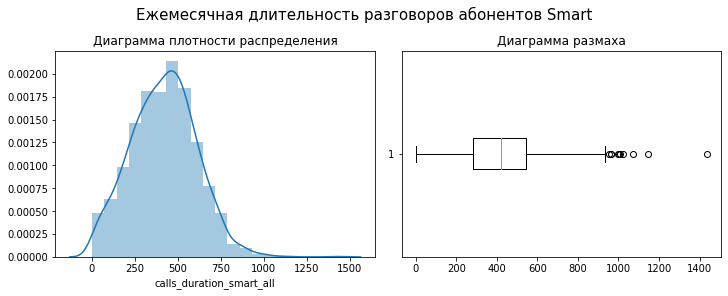

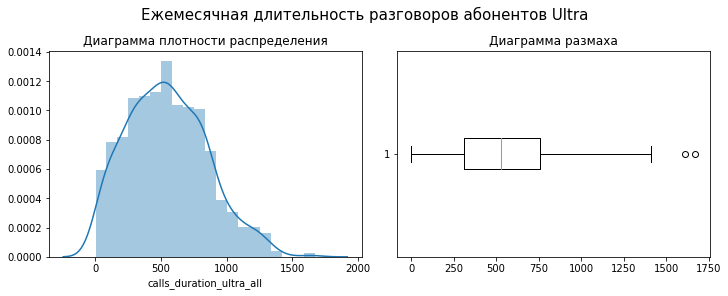

In [131]:
for tariff, data in {'Smart': calls_duration_smart_all, 'Ultra': calls_duration_ultra_all}.items():
    set_2ax_figure(f'Ежемесячная длительность разговоров абонентов {tariff}')
    
    sns.distplot(data, ax=ax1, bins=20);
    ax1.set_title('Диаграмма плотности распределения')

    ax2.boxplot(data[data.notna()], vert=False);
    ax2.set_title('Диаграмма размаха');

In [132]:
display(calls_duration_smart_all.describe())
display(calls_duration_ultra_all.describe())

count    2221.000000
mean      419.440342
std       188.992403
min         2.000000
25%       285.000000
50%       423.000000
75%       546.000000
max      1435.000000
Name: calls_duration_smart_all, dtype: float64

count     947.000000
mean      547.755016
std       305.513385
min         1.000000
25%       311.000000
50%       529.000000
75%       758.000000
max      1673.000000
Name: calls_duration_ultra_all, dtype: float64

У абонентов Smart:
- Диаграмма плотности напоминает нормальное распределение, однако, имеет выбросы справа.
- На диаграмме разброса также видны выбросы в стороне больших значений. Это означает, что находятся редкие пользователи, которые используют в месяц минут больше, нежели основная масса абонентов тарифа.
- 50% абонентов тратят от 285 до 546 минут в месяц. (в тариф включено 500 минут)

У абонентов Ultra:
- Диаграмма плотности также напоминает нормальное распределение, однако имеется скос справа.
- Разброс значений, а также интерквантильный размах больше, нежели у абонентов тарифа Smart: 50% абонентов тратят от 311 до 758 минут в месяц

In [133]:
for tariff, data in {'Smart': calls_duration_smart_all, 'Ultra': calls_duration_ultra_all}.items():
    print(f'Средняя ежемесячная продолжительность разговоров, абонентов тарифа {tariff}: {data.mean():.0f} минуты')
    print(f'Дисперсия составляет {data.std()**2:.0f} минуты')
    print(f'Стандартное отклонение составляет {data.std():.0f} минут')
    print('----------')

Средняя ежемесячная продолжительность разговоров, абонентов тарифа Smart: 419 минуты
Дисперсия составляет 35718 минуты
Стандартное отклонение составляет 189 минут
----------
Средняя ежемесячная продолжительность разговоров, абонентов тарифа Ultra: 548 минуты
Дисперсия составляет 93338 минуты
Стандартное отклонение составляет 306 минут
----------


### Количество сообщений.

Создадим функцию, которая внутри которой проделаем все выше описанные шаги, но для оставшихся двух величин: количества сообщений и объема потребляемого интернет-траффика.

In [139]:
def eda_new(data, title='Средняя ежемесячное'):
    
    'Создаем фильтры'
    smart_mask = data['tariff'] == 'smart'
    ultra_mask = data['tariff'] == 'ultra'
    
    'Создаем столбцы ежемесячными показателями для всех пользователей тарифа'
    smart_all = pd.Series(data[smart_mask].iloc[:, :12].to_numpy().flatten(), name='Smart')
    ultra_all = pd.Series(data[ultra_mask].iloc[:, :12].to_numpy().flatten(), name='Ultra')
    
    'Строим графики'
    for tariff, data_iter in {'Smart': smart_all, 'Ultra': ultra_all}.items():
        set_2ax_figure(f'{title}: абоненты {tariff}')

        sns.distplot(data_iter, ax=ax1, bins=20);
        ax1.set_title('Диаграмма плотности распределения')

        ax2.boxplot(data_iter[data_iter.notna()], vert=False);
        ax2.set_title('Диаграмма размаха');
        plt.show()
        
    'Выводим резюме'
    print('Кратное резюме:')
    for tariff, data_iter in {'Smart': smart_all, 'Ultra': ultra_all}.items():
        print(f'Абоненты {tariff}')
        print(f'Среднее {title.lower()}: {data_iter.mean():.0f}')
        print(f'Дисперсия составляет {data_iter.std()**2:.0f}')
        print(f'Стандартное отклонение составляет {data_iter.std():.0f}')
        print('----------')
    return smart_all, ultra_all

Создадим столбцы с данными `messages_smart_all` и `messages_ultra_all`. Вызозовем функцию `eda_new()`, для построения графиков и отображения резюме.

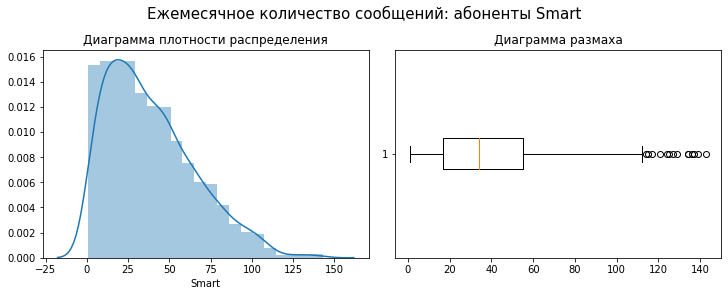

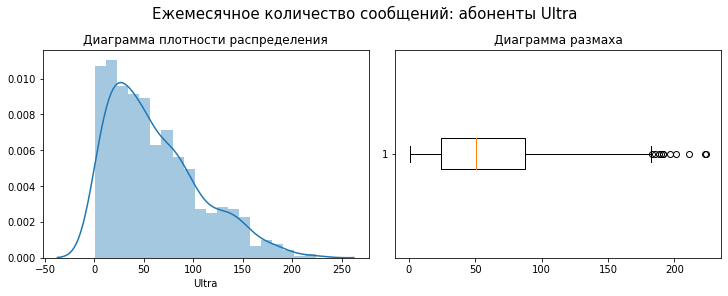

Кратное резюме:
Абоненты Smart
Среднее ежемесячное количество сообщений: 39
Дисперсия составляет 718
Стандартное отклонение составляет 27
----------
Абоненты Ultra
Среднее ежемесячное количество сообщений: 61
Дисперсия составляет 2110
Стандартное отклонение составляет 46
----------


In [140]:
messages_smart_all, messages_ultra_all = eda_new(messages_number_monthly_pivot, 
                                                 'Ежемесячное количество сообщений')

Посмотрим также на описание данных и на медианные значения.

In [141]:
display(messages_smart_all.describe())
display(messages_ultra_all.describe())

count    1922.000000
mean       38.716441
std        26.787949
min         1.000000
25%        17.000000
50%        34.000000
75%        55.000000
max       143.000000
Name: Smart, dtype: float64

count    795.000000
mean      61.161006
std       45.931026
min        1.000000
25%       24.000000
50%       51.000000
75%       87.500000
max      224.000000
Name: Ultra, dtype: float64

Возможно, нам все же стоит взять среднее арифметическое значение для отображения среднего, так как оно включает в себя и частично отображает тот самый разброс в большую сторону, присутсвие которого нам все же важно наблюдать. Тем более, что значение среднего арифметического не так сильно отличается от медианы.  

Для абонентов Smart:
- Пользователи в среднем отправляют 39 сообщений в месяц (стандартное отклонение - 27 смс). При этом, 75% абонентов отправляют в среднем менее 55 сообщений в месяц.  
- При этом ежемесячное количество сообщений колеблется от 1-го до 143 сообщений в месяц
 
Для абонентов Ultra:
- Пользователи в среднем отправляют 61 сообщение в месяц (стандартное отклонение - 46 смс). При этом, 75% абонентов отправляют в среднем менее 88 сообщений в месяц. 
- При этом ежемесячное количество сообщений колеблется от 1-го до 224 сообщений в месяц  
 
Важно также понимать, что, так как скос наблюдается в правую сторону, стандартное отклонение явялется в большей степени показателем отклонения в большую сторону от среднего.

### Объем трафика.

Создадим столбцы с данными `internet_smart_all` и `internet_ultra_all`. Вызозовем функцию `eda_new()`, для построения графиков и отображения резюме. (Там где сумарный объем траффика за месяц равен нулю, такие значения заменим на `np.nan`)

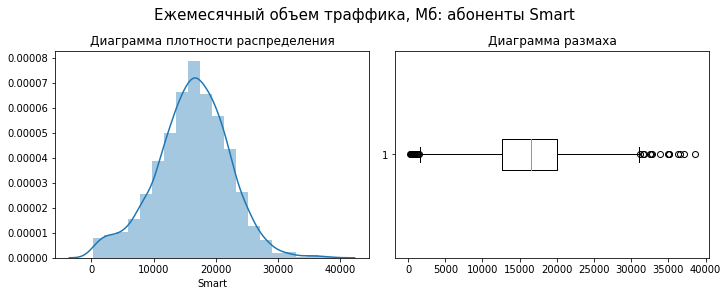

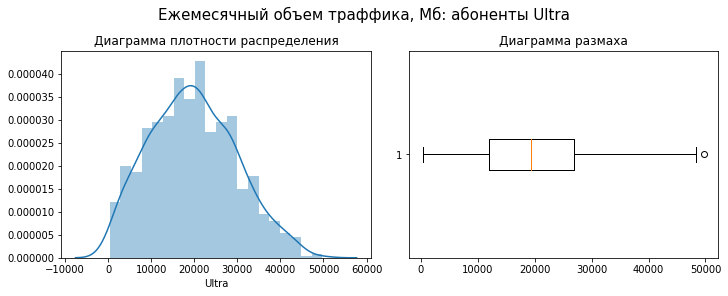

Кратное резюме:
Абоненты Smart
Среднее ежемесячный объем траффика, мб: 16223
Дисперсия составляет 34257209
Стандартное отклонение составляет 5853
----------
Абоненты Ultra
Среднее ежемесячный объем траффика, мб: 19689
Дисперсия составляет 98567864
Стандартное отклонение составляет 9928
----------


In [144]:
internet_smart_all, internet_ultra_all = eda_new(internet_monthly_pivot.where(internet_monthly_pivot != 0, np.nan), 
                                                 'Ежемесячный объем траффика, Мб')

Посмотрим также на описание данных и на медианные значения в гигабайтах. (значения округлены в большую сторону в соответсвии с условиями опреатора)

In [145]:
(
    np.ceil(internet_smart_all.describe() / 1024).iloc[1:].to_frame('Smart_GB')
    .join
    (np.ceil(internet_ultra_all.describe() / 1024).iloc[1:].to_frame('Ultra_GB'))
)

,Smart_GB,Ultra_GB
mean,16.0,20.0
std,6.0,10.0
min,1.0,1.0
25%,13.0,12.0
50%,17.0,19.0
75%,20.0,27.0
max,38.0,49.0


Для пользователей Smart:
- Диаграмма плотности напоминает форму нормального распредления, однако на графике размаха выдны выбросы как с меньшей так и с большей стороны. Иными словами, не смотря на то, что 50% значений использованного в месяц траффика расположены в достаточно узком диапазоне (13 - 20 Гб), есть пользователи, для которых характерно как использование гораздо меньшего так и гораздо большего объема траффика, чем для основной части пользователей.
- В среднем абоненты тратят 16 Гб в месяц, со стандартным отклонением в 6 Гб (при норме тарифа в 15 Гб)  

Получается, что в среднем абоненты тарифа Smart превышают включенные в тарифый пакет Гигабайты примерно на 1 Гигабайт каждый месяц, а 50% пользователей и вовсе используют более 17 Гб в месяц.

Для пользователей Ultra:
- Диаграмма плотности также напоминает форму нормального распределения.
- Интерквантильный размах использованного траффика выше, нежели для абонентов Smart: 50% абонентов тратят от 12 до 27 гигабайт в месяц.
- В среднем абоненты тратят 20 Гб в месяц, со стандартным отклонением в 10 Гб (при норме тарифа в 30 Гб)
- Лишь 25% пользователей используют свыше 26 Гб в месяц.

Получается, что в среднем, абоненты тарифа Ultra тратят меньше траффика, чем включено в их пакет.

### Резюме

На данном этапе мы изучили среднюю длительность звонков, количество сообщений и объем траффика, которые требуются абонентам в среднем ежемясячно.  
Полученные результаты выглядят следующим образом:  
    
**1. Для длительности звонков**
- Средняя ежемесячная продолжительность разговоров, абонентов тарифа Smart составляет 419 минуты со стандартным отклонением 189 минут
- 50% абонентов Smart тратят от 285 до 546 минут в месяц. (в тариф включено 500 минут)
- Средняя ежемесячная продолжительность разговоров, абонентов тарифа Ultra составляет 548 минуты со стандартным отклонением  306 минут
- Разброс значений, а также интерквантильный размах минут у абонентов Ultra больше, нежели у абонентов тарифа Smart: 50% абонентов тратят от 311 до 758 минут в месяц (в тариф включено 3000 мин)
    
Таким образом, абоненты Ultra по большей части не используют все минуты, включенные в их тариф, в то время как 25% абонентов тарифа Smart используют свыше 546 мин в месяц, при лимите в 500 мин.

**2. Для количества сообщений**
- Пользователи тарифа Smart в среднем отправляют 39 сообщения в месяц, со стандартным отклонением - 27 смс. 75% абонентов отправляют в среднем менее 55 сообщений в месяц. (при включенных в тариф 50 сообщений)  
- Среднее ежемесячное количество сообщений абонентов Smart находится в диапазоне от 1-го до 143 сообщений в месяц

- Пользователи тарифа Ultra в среднем отправляют 61 сообщения в месяц, со стандартным отклонением - 46 смс. 75% абонентов отправляют в среднем менее 88 сообщений в месяц. (при включенных в тариф 1000 сообщений)  
- Среднее ежемесячное количество сообщений абонентов Ultra находится в диапазоне от 1-го до 224 сообщений в месяц  
 
 Важно отметить, что:
- На графике распределения плотности присутсвует скос в правую сторону, что означает, стандартное отклонение явялется в большей степени показателем отклонения в большую сторону от среднего.  
- Абоненты в среднем не используют полный лимит сообщений, который у них включен в тариф. Это характерно для пользователей обоих пакетов.      
 
**3. Для объема потребляемого трафика**
- Абоненты Smart среднем тратят 16 Гб в месяц, со стандартным отклонением в 6 Гб
- 50% пользователей используют свыше 17 Гб в месяц.  при норме тарифа в 15 Гб)
- В среднем абоненты тарифа Ultra тратят 20 Гб в месяц, со стандартным отклонением в 10 Гб 
- Лишь 25% пользователей Ultra используют свыше 25.6 Гб в месяц. (при норме тарифа в 30 Гб)
 
Получается, что в среднем абоненты тарифа Smart превышают включенные в тарифный пакет трафик примерно на 1 Гигабайт каждый месяц (а половина пользователей и вовсе используют более 17 Гб при лимите в 15Гб), в то время как абоненты тарифа Ultra наоборот тратят меньше траффика, чем включено в их пакет.

## Проверка гипотез

На данном этапе проверим две гипотезы:
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;  
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### Гипотеза 1: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

На данном этапе нам пригодятся 2 таблицы:
- `total_revenue_smart` - в ней содержится выручка, полученная от абонентов на тарифе *smart* (включая ежемесячный платеж и переплаты)
- `total_revenue_ultra` - в ней содержится выручка, полученная от абонентов на тарифе *ultra* (включая ежемесячный платеж и переплаты)

Выведем на экран первые 5 строк каждого датафрейма.

In [146]:
total_revenue_smart.head()

,1,2,3,4,5,6,7,8,9,10,11,12
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1150.0,550.0
1002,NaN,NaN,NaN,NaN,NaN,550.0,1150.0,1550.0,950.0,550.0,1350.0,1150.0
1005,550.0,550.0,886.0,1186.0,835.0,886.0,775.0,949.0,556.0,1219.0,694.0,838.0
1006,NaN,550.0,950.0,550.0,550.0,550.0,1550.0,1350.0,750.0,1550.0,550.0,1350.0
1007,NaN,NaN,NaN,550.0,1150.0,685.0,981.0,1750.0,1015.0,550.0,990.0,550.0


In [147]:
total_revenue_ultra.head()

,1,2,3,4,5,6,7,8,9,10,11,12
1000,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0
1004,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
1013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,1950.0
1016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,1950.0


Подготовим данные. Сохраним значения выручки в столбцы `total_revenue_smart_all` и `total_revenue_ultra_all`

In [152]:
total_revenue_smart_all = pd.Series(total_revenue_smart.to_numpy().flatten())
total_revenue_smart_all.head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
dtype: float64

In [153]:
total_revenue_ultra_all = pd.Series(total_revenue_ultra.to_numpy().flatten())
total_revenue_ultra_all.head()

0       NaN
1       NaN
2       NaN
3       NaN
4    1950.0
dtype: float64

Посмотрим на средние значения выручки для пользователей каждого тарифа.

In [154]:
print('Средняя ежемесячная выручка абонентов Smart и Ultra:', 
      round(total_revenue_smart_all.mean()), '|', round(total_revenue_ultra_all.mean()))

print('Медианная ежемесячная выручка абонентов Smart и Ultra:', 
      round(total_revenue_smart_all.median()), '|', round(total_revenue_ultra_all.median()))

print('Объем выборки абонентов Smart и Ultra:', 
      total_revenue_smart_all.count(), '|', total_revenue_ultra_all.count())

Средняя ежемесячная выручка абонентов Smart и Ultra: 1290 | 2070
Медианная ежемесячная выручка абонентов Smart и Ultra: 1023 | 1950
Объем выборки абонентов Smart и Ultra: 2229 | 985


Абонентов Smart у нас представлено практически в 2 раза больше, чем абонентов Ultra.  
Средняя и медианная ежемесячная выручка абонентов Ultra выше чем у абонентов Smart практически в 2 раза. При этом, интересно также заметить, что абоненты тарифа Smart в среднем платят более чем в два раза больше, нежели стоимость ежемесячного обслуживания.  
Также, можно увидеть, что среднее арифметическое больше медианного значения, из чего можно предлоложить, что график распределение средней ежемесячной выручки будет скошен вправо для абонентов обеих выборок.

Посмотрим на гистограммы распределение данных для каждой из выборок.

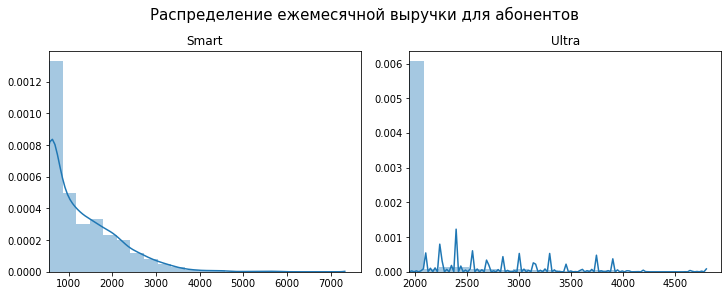

In [155]:
set_2ax_figure('Распределение ежемесячной выручки для абонентов')

sns.distplot(total_revenue_smart_all, bins=20, ax=ax1)
ax1.set_xlim(total_revenue_smart_all.min())
ax1.set_title('Smart')

sns.distplot(total_revenue_ultra_all, bins=20, ax=ax2)
ax2.set_xlim(total_revenue_ultra_all.min())
ax2.set_title('Ultra');

Сформулируем гипотезы:  
- Нулевая гипотеза (H0): показатели средней ежемесячной выручки для абонентов Smart и Ultra равны между собой.
- Альтернативная гипотеза (H1): показатели средней ежемесячной выручки для абонентов Smart и Ultra различаются.

Мы имеем 2 независимые выборки. Распределения выборок не являются нормальными.  Распределения обоих выборок имеют скос справа.  
Мы не знаем, как распределены генеральные совокупности. Нам не известна дисперсия для генеральных совокупностей. 

Для проверки двусторонней гипотезы воспользуемся непараметрически критерием Манна-Уитни. В качестве уровня значимости примем значение alpha = 0.05  
Критерий Манна-Уитни фактически проверяет гипотезу о том, что значения в столбце Х превышают значения в столбце У также часто, как значения в столбце У превышают значения в столбце Х.  

In [156]:
_, pvalue = st.mannwhitneyu(total_revenue_smart_all, total_revenue_ultra_all) 

alpha = 0.05

print('pvalue:', pvalue)
if pvalue < (alpha / 2): # Так как гипотеза двухсторонняя, делим значение alpha на 2.
    print('Отвергаем гипотезу H0')
else:
    print('Гипотеза HO не может быть отвергнута')

pvalue: 9.131251743979247e-05
Отвергаем гипотезу H0


Проверим также одностороннюю гипотезу.  
Альернативную гипотезу в данном случае сформулируем следующим образом: средняя ежемесячная выручка абонентов Ultra выше нежели у абонентов Smart

In [157]:
_, pvalue = st.mannwhitneyu(total_revenue_smart_all, total_revenue_ultra_all)

alpha = 0.05

print('pvalue:', pvalue)
if pvalue < alpha and total_revenue_ultra_all.mean() > total_revenue_smart_all.mean():
    print('Отвергаем гипотезу H0')
else:
    print('Гипотеза HO не может быть отвергнута')

pvalue: 9.131251743979247e-05
Отвергаем гипотезу H0


**Вывод**

При уровне значимости 5%, мы можем утверждать, что выручка, которую приносят нам пользователи тарифа Smart и Ultra различаются.  
Более того, при уровне значимости 5% мы можем утверждать, что средняя ежемесячная выручка пользователей тарифа Ultra выше, нежели у абонентов Smart.

### Гипотеза 2: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Для проверки данной гипотезы нам необходимо 2 столбца: столбец со среднемесячной выручкой пользователей из Москвы и столбец со среднемесячной выручкой абонентов из регионов.

Создадим таблицу, в которой сохраним для каждого пользователя город его проживания.  
Заменим все регионы на значение 'Регион'.
Сохраним словарь "Пользователь - Регион проживания" в таблицу `users_city_dict`

In [158]:
users_city_dict = data_users[['user_id', 'city']].set_index('user_id')
users_city_dict = users_city_dict.where(users_city_dict['city'] == 'Москва', 'Регион')

users_city_dict.head()

,city
user_id,
1000,Регион
1001,Москва
1002,Регион
1003,Москва
1004,Регион


Подготовим данные.

In [162]:
# Присоеденим столбце с городом для каждого абонента к таблицам, в которых хранится выручка
total_revenue_smart_city = total_revenue_smart.join(users_city_dict)
total_revenue_ultra_city = total_revenue_ultra.join(users_city_dict)

Создадим столбцы `total_revenue_moscow` и `total_revenue_region`  в которые сохраним ежемесячную выручку, полученную от пользователей из Москвы и из регионов.

In [163]:
total_revenue_moscow = pd.Series(
    np.append(
    # Массив пользователей smart из Москвы
    total_revenue_smart_city[total_revenue_smart_city['city'] == 'Москва'].iloc[:, :12].to_numpy().flatten(), 
    # Массив пользователей ultra из Москвы
    total_revenue_ultra_city[total_revenue_ultra_city['city'] == 'Москва'].iloc[:, :12].to_numpy().flatten()
    )
)


total_revenue_region = pd.Series(
    np.append(
    # Массив пользователей smart из Москвы
    total_revenue_smart_city[total_revenue_smart_city['city'] == 'Регион'].iloc[:, :12].to_numpy().flatten(), 
    # Массив пользователей ultra из Москвы
    total_revenue_ultra_city[total_revenue_ultra_city['city'] == 'Регион'].iloc[:, :12].to_numpy().flatten()
    )
)

Данные готовы. Можно приступать к проверке гипотезы.

Посмотрим на средние значения выручки для пользователей из Москвы и регионов.

In [164]:
print('Средняя ежемесячная выручка абонентов из Москвы и регионов:', 
      round(total_revenue_moscow.mean()), '|', round(total_revenue_region.mean()))

print('Медианная ежемесячная выручка абонентов из Москвы и регионов:', 
      round(total_revenue_moscow.median()), '|', round(total_revenue_region.median()))

print('Объем выборки абонентов из Москвы и регионов:', 
      total_revenue_moscow.count(), '|', total_revenue_region.count())

Средняя ежемесячная выручка абонентов из Москвы и регионов: 1547 | 1525
Медианная ежемесячная выручка абонентов из Москвы и регионов: 1750 | 1583
Объем выборки абонентов из Москвы и регионов: 611 | 2603


Абонентов из регионов представлено практически в 4 раза больше, чем абонентов из Москвы.  
Средняя ежемесячная выручка абонентов из Москвы незначительно ниже, чем средняя ежемесячная выручка абонентов из регионов.

Посмотрим на гистограммы распределение данных для каждой из выборок.

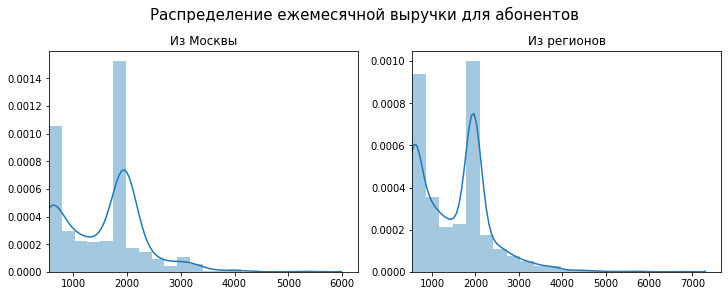

In [165]:
set_2ax_figure('Распределение ежемесячной выручки для абонентов')

sns.distplot(total_revenue_moscow, bins=20, ax=ax1)
ax1.set_xlim(total_revenue_moscow.min())
ax1.set_title('Из Москвы')

sns.distplot(total_revenue_region, bins=20, ax=ax2)
ax2.set_xlim(total_revenue_region.min())
ax2.set_title('Из регионов');

Если обратить внимание на функцию ядерного сглаживания для оценки плотности, можно увидеть 2 пика - в районе ~1000~ 900 и в районе 2000. Вероятнее всего причина состоит в том, что в обоих выборках присутсвуют 2 категории клиентов: пользователи тарифа Smart и Ultra.  
Данное распределение напоминает бимодальное и не является нормальным.  
Интересно, как будут выглядеть распределения, если отобразить их на одном графике.

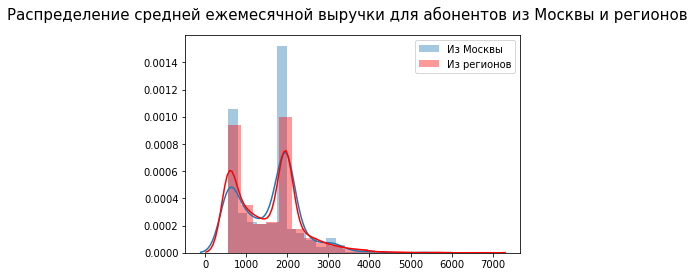

In [166]:
fig, ax1 = plt.subplots()
fig.suptitle('Распределение средней ежемесячной выручки для абонентов из Москвы и регионов', fontsize=15)

sns.distplot(total_revenue_moscow, bins=20, ax=ax1, label='Из Москвы')
sns.distplot(total_revenue_region, bins=20, ax=ax1, color='r', label='Из регионов');
plt.legend();

Видно, что распределения очень похожи между собой. Функции ядерного сглаживания практически накладываются одна на другую.

Сформулируем гипотезы:  
- Нулевая гипотеза (H0): показатели средней ежемесячной выручки для абонентов из Москвы и регионов равны между собой.
- Альтернативная гипотеза (H1): показатели средней ежемесячной выручки для абонентов из Москвы и регионов различаются.

Мы имеем 2 независимые выборки. Распределения выборок не являются нормальными.  Распределения похожи между собой.  
Мы не знаем, как распределены генеральные совокупности. Нам не известна дисперсия для генеральных совокупностей. 

Для проверки двусторонней гипотезы воспользуемся непараметрически критерием Манна-Уитни. В качестве уровня значимости примем значение alpha = 0.05    

In [168]:
st.mannwhitneyu([i for i in total_revenue_moscow if np.isnan(i)!=True], 
                [i for i in total_revenue_region if np.isnan(i)!=True])

MannwhitneyuResult(statistic=777131.5, pvalue=0.18711697455182996)

In [169]:
_, pvalue = st.mannwhitneyu([i for i in total_revenue_moscow if np.isnan(i)!=True], 
                            [i for i in total_revenue_region if np.isnan(i)!=True])


alpha = 0.05

print('pvalue:', pvalue)
if pvalue < (alpha / 2): # Так как гипотеза двухсторонняя, делим значение alpha на 2.
    print('Отвергаем гипотезу H0')
else:
    print('Гипотеза HO не может быть отвергнута')

pvalue: 0.18711697455182996
Гипотеза HO не может быть отвергнута


**Вывод**

При уровне значимости 5% мы не имеем достаточно оснований для того, чтобы отвергнуть утверждение о том, что средняя ежемесячная выручка абонентов из Москвы и абонентов из регионов равна между собой.

### Резюме

На данном этапе были проверены 2 гипотезы. Для проверки обеих гипотез был использован критерий Манна-Уитни. Были получены следующие результаты:  
- Гипотеза 1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются:  

Результат проверки: при уровне значимости 5%, мы можем утверждать, что выручка, которую приносят нам пользователи тарифа Smart и Ultra различаются. Средняя ежемесячная выручка от абонентов Ultra выше. (Средняя ежемесячная выручка абонентов Smart и Ultra: ~1324 руб. и 2086 руб~ 1290 и 2070 руб. соотвественно)

- Гипотеза 2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. 

Результат проверки: при уровне значимости 5% у нас недостаточно оснований отвергнуть утверждение о том, что средняя ежемесячная выручка абонентов из Москвы и абонентов из регионов равна между собой.

## Подведение итогов

**В ходе работы были предприняты следующие шаги:**  
- Была осуществлена предобработка данных
- Была произведена подготовка данных к анализу
- Был произведен исследовательский анализ данных
- Была произведена проверка гипотез с использованием статистических методов  
  
**1. В ходе предобработки данных, мы:**
- Привели данные к соответствущим типам
- Проверили данные на предмет ошибочных значений и дубликатов. Исправили там, где было необходимо.
- На основе имеющихся признаков, добавили новые, там, где это было необходимо для целей исследования.

**2. На этапе подготовки данных к анализу, мы произвели рассчет необходимых метрик и сохранили их в соотвествующие таблицы.** На основании этих таблиц были произведены дальнейшие шаги по иссследовательской работе. На данном этапе было подсчитано:
- Количество звонков по каждому пользователю в месяц (длительностью свыше нуля) (таблица `calls_number_monthly_pivot`)
- Суммарная продолжительность звонков по каждому пользователю за месяц (каждый звонок перед подсчетом суммы был округлен в большую сторону, в соответствии с условиями оператора) (таблица `calls_duration_monthly_pivot`)
- Количество сообщений, отправленных каждым пользователем за месяц (таблица `messages_number_monthly_pivot`)
- Количество трафика, которые абоненты использовали за месяц (таблица `internet_monthly_pivot`)
- Выручка, полученная от абонентов на тарифе *smart* (включая ежемесячный платеж и переплаты) (таблица `total_revenue_smart` )
- Выручка, полученная от абонентов на тарифе *ultra* (включая ежемесячный платеж и переплаты) (таблица `total_revenue_ultra`)
 
**3. На этапе исследовательского анализа данных, мы изучили среднюю длительность звонков, количество сообщений и объем траффика, которые требуются абонентам в среднем ежемясячно.** Были получены следующие результаты:  

Что касается звонков:  
- Средняя ежемесячная продолжительность разговоров, абонентов тарифа Smart составляет 419 минуты со стандартным отклонением 189 минут. 50% абонентов Smart тратят от 285 до 546 минут в месяц. (в тариф включено 500 минут)
- Средняя ежемесячная продолжительность разговоров, абонентов тарифа Ultra составляет 548 минуты со стандартным отклонением  306 минут. Разброс значений, а также интерквантильный размах минут у абонентов Ultra больше, нежели у абонентов тарифа Smart: 50% абонентов тратят от 311 до 758 минут в месяц (в тариф включено 3000 мин)

Таким образом, абоненты Ultra по большей части не используют все минуты, включенные в их тариф, в то время как 25% абонентов тарифа Smart используют свыше 546 мин в месяц, при лимите в 500 мин. 
    
Что касается сообщений:
- Пользователи тарифа Smart в среднем отправляют 39 сообщения в месяц, со стандартным отклонением - 27 смс. 75% абонентов отправляют в среднем менее 55 сообщений в месяц. (при включенных в тариф 50 сообщений)  
- Среднее ежемесячное количество сообщений абонентов Smart находится в диапазоне от 1-го до 143 сообщений в месяц
- Пользователи тарифа Ultra в среднем отправляют 61 сообщения в месяц, со стандартным отклонением - 46 смс. 75% абонентов отправляют в среднем менее 88 сообщений в месяц. (при включенных в тариф 1000 сообщений)  
- Среднее ежемесячное количество сообщений абонентов Ultra находится в диапазоне от 1-го до 224 сообщений в месяц      
 
При этом, стандартное отклонение в данном случае явялется в большей степени показателем отклонения в большую сторону от среднего.  
Абоненты в среднем не используют полный лимит сообщений, который у них включен в тариф. Это характерно для пользователей обоих пакетов. 
   
Что касается объема потребляемого трафика:
- Абоненты Smart среднем тратят 16 Гб в месяц, со стандартным отклонением в 6 Гб
- 50% пользователей используют свыше 17 Гб в месяц.  при норме тарифа в 15 Гб)
- В среднем абоненты тарифа Ultra тратят 20 Гб в месяц, со стандартным отклонением в 10 Гб 
- Лишь 25% пользователей Ultra используют свыше 25.6 Гб в месяц. (при норме тарифа в 30 Гб)
 
В среднем абоненты тарифа Smart превышают включенные в тарифный пакет трафик на 1 Гигабайт каждый месяц (а половина пользователей и вовсе используют более 17 Гб при лимите в 15Гб), в то время как абоненты тарифа Ultra наоборот тратят меньше траффика, чем включено в их пакет.

**4. На этапе проверки гипотез, были проверены 2 гипотезы.** Для проверки обеих гипотез был использован непараметрический критерий Манна-Уитни. Были получены следующие результаты:
- Гипотеза 1: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.  

Средняя ежемесячная выручка абонентов Smart и Ultra: 1290 и 2070 руб. соотвественно.  
Интересный факт: абоненты тарифа Smart в среднем ежемесячно платят примерно в 2 раза больше, нежели стоимость их тарифного плана.  
При уровне значимости 5%, мы можем утверждать, что средняя выручка, которую приносят нам абоненты тарифа Smart и абоненты тарифа Ultra различается.  
Более того, при том же уровне значимости, мы можем утверждать, что средняя ежемесячная выручка пользователей тарифа Ultra выше, нежели у абонентов Smart.

- Гипотеза 2: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.  

При уровне значимости 5% у нас недостаточно оснований отвергнуть гипотезу о том, что средняя ежемесячная выручка абонентов из Москвы и абонентов из регионов равна между собой. 


**Краткое резюме**  
Абоненты тарифа Ultra в среднем ежемесячно приносит больше выручки, нежели пользователи тарифа Smart. Эта разница статистически значима.  
Разница же между выручкой абонентов из Москвы и абонентов из регионов статистически не значима.  